# p-hacking

A significância estatística (p-value) é um medida importante nas análises de dados. Porém, um bom valor p (menor que 0.05 ou 0.01) não é necessariamente indicador de uma pesquisa bem feita. Pior: nos últimos anos uma corrida por valores baixos para p resultou em análises pobres, que obtêm bons valores de p usando técnicas questionáveis. O termo usado para este tipo de análise é p-hacking. 

Este notebook apresenta algumas técnicas usadas para obter bons valores p. Pesquisas que usam estes tipos de estratégias devem ser repudiadas pela comunidade científica.

In [296]:
#importing libraries
import pandas as pd
import numpy as np
import scipy.stats as stat
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Configurando o "experimento"

Para demonstrar os problemas com p-hacking vamos construir um esperimento analisando características de ratos (gerados aleatoriamente) e doenças.

## Criando o DataFrame e adicionando variáveis categóricas

Abaixo configuramos nossa geração aleatória de ratos para compor o DataFrame de análise.

In [297]:
# número de ratos que serão gerados com valores aleatórios 
num_ratos = 500

# valores possíveis para variáveis categóricas
genero = ('M', 'F')
cor_pelo = ('preto', 'branco', 'cinza', 'rajado', 'outra')
cor_olho = ('preto', 'vermelho', 'marrom')

# semente de geração de números aleatórios (altere para ver como os resultados mudam)
np.random.seed(42)

ratos_df = pd.DataFrame()

ratos_df['genero'] = np.random.choice(genero, size=num_ratos)
ratos_df['cor_pelo'] = np.random.choice(cor_pelo, size=num_ratos, p=(0.3, 0.25, 0.25, 0.1, 0.1))
ratos_df['cor_olho'] = np.random.choice(cor_olho, size=num_ratos, p=(0.7, 0.2, 0.1))
ratos_df.head()

,genero,cor_pelo,cor_olho
0,M,preto,preto
1,F,branco,marrom
2,M,rajado,preto
3,M,branco,preto
4,M,preto,preto


Para as análises de correlação, precisamos converter as variáveis categóricas em valores 0 e 1:

In [298]:
ratos_df = pd.get_dummies(ratos_df, prefix=ratos_df.columns)

ratos_df.head()

,genero_F,genero_M,cor_pelo_branco,cor_pelo_cinza,cor_pelo_outra,cor_pelo_preto,cor_pelo_rajado,cor_olho_marrom,cor_olho_preto,cor_olho_vermelho
0,0,1,0,0,0,1,0,0,1,0
1,1,0,1,0,0,0,0,1,0,0
2,0,1,0,0,0,0,1,0,1,0
3,0,1,1,0,0,0,0,0,1,0
4,0,1,0,0,0,1,0,0,1,0


## Adicionando variáveis contínuas

Para aumentar nossas chances de obter resultados significativos, vamos adicionar mais variáveis. Inserimos a seguir diversas medidas de tamanho da anatomia dos ratos fictícios. 



In [299]:
# retorna um tamanho baseado numa escala e um desvio (para que o tamanho seja proporcional ao tamanho do rato nas tenho uma pequena variância)
def gera_tamanho(tamanho_base, escala, sigma_desvio = 0.1):
    return tamanho_base * escala + np.random.normal(0, sigma_desvio)


In [300]:
# membros a serem adicionados
membros = {'pata':{'numero':4, 'escala':0.1, 'sigma_desvio':0.1}, 
           'dedo':{'numero':20, 'escala':0.05, 'sigma_desvio':0.01}, 
           'orelha':{'numero':2, 'escala':0.05, 'sigma_desvio':0.05} }

# define o tamanho dos ratos
media_tamanho = 20
desvio_tamanho = 2
ratos_df['tamanho'] = np.random.normal(media_tamanho, desvio_tamanho, num_ratos)

for membro, parametro in membros.items():
    for n in range(1, parametro['numero'] + 1):
        ratos_df[membro + str(n)] = ratos_df['tamanho'].apply(lambda t: gera_tamanho(t, parametro['escala'], parametro['sigma_desvio']))
        
ratos_df.head()

,genero_F,genero_M,cor_pelo_branco,cor_pelo_cinza,cor_pelo_outra,cor_pelo_preto,cor_pelo_rajado,cor_olho_marrom,cor_olho_preto,cor_olho_vermelho,...,dedo13,dedo14,dedo15,dedo16,dedo17,dedo18,dedo19,dedo20,orelha1,orelha2
0,0,1,0,0,0,1,0,0,1,0,...,0.996395,1.006918,0.988347,0.993920,1.023904,0.982775,0.993608,0.976458,1.004059,0.999962
1,1,0,1,0,0,0,0,1,0,0,...,1.131516,1.149023,1.136924,1.142309,1.142600,1.144476,1.141125,1.137764,1.209889,1.135321
2,0,1,0,0,0,0,1,0,1,0,...,0.946697,0.927494,0.924167,0.938713,0.929103,0.933140,0.929460,0.937151,0.961044,0.982159
3,0,1,1,0,0,0,0,0,1,0,...,1.161497,1.179992,1.191679,1.169832,1.181227,1.195535,1.184312,1.171558,1.182982,1.216905
4,0,1,0,0,0,1,0,0,1,0,...,0.989136,0.996618,1.008222,1.002087,0.993557,0.999835,1.011246,0.998622,1.027971,0.946829


In [301]:
# variavel com todas as caracteristicas definidas
caracteristicas = ratos_df.columns

caracteristicas

Index(['genero_F', 'genero_M', 'cor_pelo_branco', 'cor_pelo_cinza',
       'cor_pelo_outra', 'cor_pelo_preto', 'cor_pelo_rajado',
       'cor_olho_marrom', 'cor_olho_preto', 'cor_olho_vermelho', 'tamanho',
       'pata1', 'pata2', 'pata3', 'pata4', 'dedo1', 'dedo2', 'dedo3', 'dedo4',
       'dedo5', 'dedo6', 'dedo7', 'dedo8', 'dedo9', 'dedo10', 'dedo11',
       'dedo12', 'dedo13', 'dedo14', 'dedo15', 'dedo16', 'dedo17', 'dedo18',
       'dedo19', 'dedo20', 'orelha1', 'orelha2'],
      dtype='object')

## Adicionando variáveis de resposta (doenças)

Usar várias variáveis de resposta aumenta nossa chance de encontrar uma correlação significativa. O certo seria ter definido uma hipótese anteriormente e apenas usar a variável de resposta da hipótese.


In [302]:
# preenchendo colunas de doenças com ocorrências aleatórias
ratos_df['cancer'] = np.random.choice((0, 1), size=num_ratos, p=(0.9, 0.1))
ratos_df['obesidade'] = np.random.choice((0, 1), size=num_ratos, p=(0.7, 0.3))
ratos_df['depressão'] = np.random.choice((0, 1), size=num_ratos, p=(0.8, 0.2))
ratos_df['diabetes'] = np.random.choice((0, 1), size=num_ratos, p=(0.8, 0.2))

# variável contendo todas as doenças 
doencas = ratos_df.columns[-4:]

ratos_df.head()

,genero_F,genero_M,cor_pelo_branco,cor_pelo_cinza,cor_pelo_outra,cor_pelo_preto,cor_pelo_rajado,cor_olho_marrom,cor_olho_preto,cor_olho_vermelho,...,dedo17,dedo18,dedo19,dedo20,orelha1,orelha2,cancer,obesidade,depressão,diabetes
0,0,1,0,0,0,1,0,0,1,0,...,1.023904,0.982775,0.993608,0.976458,1.004059,0.999962,0,0,0,0
1,1,0,1,0,0,0,0,1,0,0,...,1.142600,1.144476,1.141125,1.137764,1.209889,1.135321,0,1,0,0
2,0,1,0,0,0,0,1,0,1,0,...,0.929103,0.933140,0.929460,0.937151,0.961044,0.982159,0,1,0,0
3,0,1,1,0,0,0,0,0,1,0,...,1.181227,1.195535,1.184312,1.171558,1.182982,1.216905,0,0,0,0
4,0,1,0,0,0,1,0,0,1,0,...,0.993557,0.999835,1.011246,0.998622,1.027971,0.946829,0,0,1,0


# Calculando p-values

As funções abaixo calculam os p-values para cada par de característica/doença.

In [303]:
# retorna p-value da correlação entre duas colunas (c, f)
def findpvalue(data, c, f):
    return stat.pearsonr(data[c].tolist(), data[f].tolist())

# retorna todos os pares de característica/doença 
def getSignificantCorr(data, caracteristicas, doencas):
    pvalues = pd.DataFrame(columns=['caracteristica', 'doenca', 'corr', 'p'])
    for c in caracteristicas:
        for d in doencas:
            stats = findpvalue(data, c, d)
            pvalues.loc[len(pvalues)] = [c, d, stats[0], stats[1]]

    pvalues = pvalues[pvalues['p'] < 0.01]
    return pvalues



## Analisando resultados

Abaixo mostramos as características que foram identificadas como tendo correlação significativa com as doenças. Mesmo usando o critério mais estrito de significância (p < 0.01 em vez de p < 0.05), duas variáveis foram identificadas como significativas. Interessante perceber que apesar do p-value significativo, o efeito é bem pequeno, tanto analisando o valor das correlações quanto o boxplot abaixo.

In [304]:
getSignificantCorr(ratos_df, caracteristicas, doencas)

,caracteristica,doenca,corr,p
10,cor_pelo_branco,depressão,0.125066,0.005101
47,pata1,diabetes,0.124207,0.005416


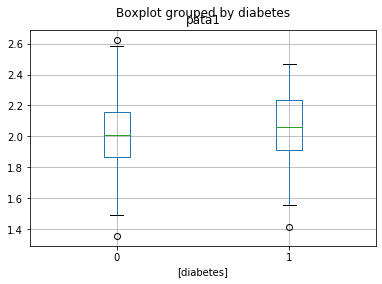

In [305]:
ratos_df[['pata1', 'diabetes']].boxplot(by='diabetes')

## Analisando grupos para obter mais associações "significativas"

Um pesquisador desonesto insatisfeito com os resultados obtidos pode ainda filtrar os dados por grupos para tentar obter outras associações. Por exemplo, abaixo fazemos os experimentos separando os ratos de acordo com a cor dos olhos. Veja que dependendo da cor, outros pares de característica/doença são identificados.

In [306]:
for c in cor_olho:
    print('Resultados para cor: {}'.format(c))
    coluna = 'cor_olho_' + c
    ratos_filtrados = ratos_df[ratos_df[coluna] == 1]
    display(getSignificantCorr(ratos_filtrados, caracteristicas, doencas))

Resultados para cor: preto


,caracteristica,doenca,corr,p
47,pata1,diabetes,0.144705,0.007182
56,pata4,cancer,0.139132,0.009775
63,dedo1,diabetes,0.141794,0.008448
67,dedo2,diabetes,0.143088,0.007862
103,dedo11,diabetes,0.140820,0.008913
115,dedo14,diabetes,0.143871,0.007526


Resultados para cor: vermelho


,caracteristica,doenca,corr,p
1,genero_F,obesidade,0.280123,0.004159
5,genero_M,obesidade,-0.280123,0.004159


Resultados para cor: marrom


,caracteristica,doenca,corr,p


# Sumário

Este notebook demostrou como é possível obter resultados estatisticamente significativos a partir de dados aleatórios. O principal problema neste caso é a falta de uma hipótese inicial. Testes estatísticos supõem uma hipótese. Considerar todas as combinações de caracteríticas e efeitos leva à geração de resultados espúrios, como demonstrado. 

Mesmo com a adoção de uma hipótese inicial, pesquisas desonestas podem aplicar outras metodologias questionáveis para obter resultados significativos. A ferramenta [p-hacker](https://shinyapps.org/apps/p-hacker/) permite a definição de experimentos e aplicações de diversas técnicas desonestas para aumentar os valores p.